In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (16,10)
# plt.style.use("~/.dracula.mplstyle")
import quandl
import functools
import statsmodels.api as sm
from collections import Counter

# QUANDL Config
import os, sys
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
from common.config import QUANDL_API_KEY  # If you are not Philip, you don't have config
                                          # unless you make your own.
from common.functions import portstats_bm

quandl.ApiConfig.api_key = QUANDL_API_KEY # Replace with your API key if running.

# 1 Introduction

A spread trading strategy checks a running estimate of the displacement between two related instruments, and makes bets that this displacement will decline whenever it gets large. Here, we define that displacement in terms of recent returns.

## Defining `GLOBAL CONST` variables

These will not be changed throughout the notebook and can be adaped to work with different trading pairs across different time ranges.

In [2]:
START_DATE    = "2019-12-02"
END_DATE      = "2021-12-31"

QUANDL_DB     = "QUOTEMEDIA/PRICES"
QUANDL_ASSETS = ["FCOM", "VOX"]

FF_TABLE      = "F-F_Research_Data_Factors_daily"
FF_DB         = "famafrench"

In [3]:
if "pull_quandl" in globals():
    print("Not re-defining.")
else:
    print("Defining quandl pull")
    @functools.lru_cache(maxsize=16)
    def pull_quandl(db, assets, start_date, end_date):
        ret = quandl.get_table(db, ticker=list(assets), 
                               date={"gte":START_DATE, "lte":END_DATE})
        return ret

eod_raw = pull_quandl(QUANDL_DB, tuple(QUANDL_ASSETS), START_DATE, END_DATE)
display(eod_raw.head(3))

Defining quandl pull


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
None,,,,,,,,,,,,,,
0,VOX,2021-12-31,136.8700,137.3300,135.5100,135.5600,78065.0000,0.0000,1.0000,136.8700,137.3300,135.5100,135.5600,78065.0000
1,VOX,2021-12-30,136.7800,137.9900,136.7800,137.1900,114214.0000,0.0000,1.0000,136.7800,137.9900,136.7800,137.1900,114214.0000
2,VOX,2021-12-29,137.1000,137.5300,136.0950,136.5000,97534.0000,0.0000,1.0000,137.1000,137.5300,136.0950,136.5000,97534.0000


In [4]:
ff_raw = pdr.data.DataReader(FF_TABLE, FF_DB, 
                            ''.join(START_DATE.split('-')),
                            ''.join(END_DATE.split('-')))

ff_raw[0].head(3)

,Mkt-RF,SMB,HML,RF
Date,,,,
2019-12-02,-0.8700,-0.2400,0.4600,0.0070
2019-12-03,-0.6600,0.6000,-0.8300,0.0070
2019-12-04,0.6000,0.1300,0.2500,0.0070


## Using Log Returns

Because with daily data log and simple returns are nearly equivlent. Working with log returns is also easier as they compound by addition rather than multiplication.

Note: Fama French data is also quoted in percentage points rather than decimal (i.e. 1.00 denotes 1%=0.01). I have normalized it.

In [5]:
q_adj_close = eod_raw[["date", "ticker", "adj_close"]].pivot(
    index="date", columns="ticker", values="adj_close")
q_log_ret = np.log(q_adj_close / q_adj_close.shift(1))

f_ret = np.log(ff_raw[0] / 100 + 1)
f_ret.index.name = "date"
f_level = np.exp(f_ret.cumsum())

levels = q_adj_close.merge(f_level, how="left", on="date")
ret = q_log_ret.merge(f_ret, on="date")

etfs_facts = pd.concat([levels, ret], axis=1, keys=["level", "ret"])
display(etfs_facts)

level                                          ret          \
              FCOM      VOX Mkt-RF    SMB    HML     RF    FCOM     VOX   
date                                                                      
2019-12-02 34.0275  89.3003 0.9913 0.9976 1.0046 1.0001     NaN     NaN   
2019-12-03 34.0079  89.1632 0.9848 1.0036 0.9963 1.0001 -0.0006 -0.0015   
2019-12-04 34.1549  89.6723 0.9907 1.0049 0.9988 1.0002  0.0043  0.0057   
2019-12-05 34.2921  89.9464 0.9920 1.0028 1.0033 1.0003  0.0040  0.0031   
2019-12-06 34.5077  90.5143 1.0010 1.0052 1.0073 1.0004  0.0063  0.0063   
...            ...      ...    ...    ...    ...    ...     ...     ...   
2021-12-27 52.0700 137.4700 1.5783 1.0944 0.8495 1.0052  0.0066  0.0072   
2021-12-28 51.9700 137.2300 1.5741 1.0879 0.8563 1.0052 -0.0019 -0.0017   
2021-12-29 51.7500 136.5000 1.5750 1.0873 0.8576 1.0052 -0.0042 -0.0053   
2021-12-30 52.0000 137.1900 1.5727 1.0884 0.8544 1.0052  0.0048  0.0050   
2021-12-31 51.3600 135.5600 1.5678 1.0890 0.8589 1.0052 -0.0124 -0.0120   

                                           
            Mkt-RF     SMB     HML     RF  
date                                       
2019-12-02 -0.0087 -0.0024  0.0046 0.0001  
2019-12-03 -0.0066  0.0060 -0.0083 0.0001  
2019-12-04  0.0060  0.0013  0.0025 0.0001  
2019-12-05  0.0013 -0.0021  0.0046 0.0001  
2019-12-06  0.0091  0.0024  0.0039 0.0001  
...            ...     ...     ...    ...  
2021-12-27  0.0121 -0.0009  0.0028 0.0000  
2021-12-28 -0.0027 -0.0059  0.0080 0.0000  
2021-12-29  0.0006 -0.0006  0.0015 0.0000  
2021-12-30 -0.0015  0.0010 -0.0038 0.0000  
2021-12-31 -0.0031  0.0006  0.0053 0.0000  

[526 rows x 12 columns]

# 2 Data

Obtain split- and dividend-adjusted closing prices1 for 2 Dec 2019 though 31 Dec 2021 of a pair of ETFs (which we will call X and Y ) as specified below. Estimate daily dollar volume, compute the running trailing 15-trading-day median of it over our sample period for X, and denote that running median (as of any day given t) for the less liquid of the two ETFs with the expression Nt.

In [6]:
q_adj_volm = eod_raw[["date", "ticker", "adj_volume"]].pivot(
    index="date", columns="ticker", values="adj_volume")

V_t = q_adj_volm * q_adj_close

window = 15

med = V_t.rolling(window).median().shift(1) # Shift to avoid lookahead bias
less_liquid = med.mean().idxmin()
N_t = med[less_liquid] # For position sizing
etfs_facts[("volm", "N_t")] = N_t
N_t[~N_t.isna()]

date
2019-12-23   1728917.1273
2019-12-24   1682752.4332
2019-12-26   1667148.7383
2019-12-27   1650773.4719
2019-12-30   1650773.4719
                 ...     
2021-12-27   4949595.1180
2021-12-28   4856834.6400
2021-12-29   4727868.5232
2021-12-30   4433092.9700
2021-12-31   4433092.9700
Name: FCOM, Length: 511, dtype: float64

# 3 Exercise 

## 3.1 Positions

Create code for a spread-reversion trading strategy that begins on the first day of each month, trades during the month, and closes any open positions the end of each month (i.e. the first potential day for a trade is just after January 1 2020). For this homework, make the unrealistic assumption that you can trade at end-of-day closing prices from the database.

Its trades are equal-sized dollar amounts of X and Y to the nearest integer number of shares, as close as possible to \\$ Nt / 100 of each. Note that Nt changes every day, so trade size will depend on which day you open the position. Your gross traded cash is therefore roughly \\$2Nt/100. Track this number on any open position for later stop loss calculations.

The strategy enters or maintains a position if the size s of difference between the M-day return on X and Y is greater than g, and flattens (exits) the position if the size of the difference is less than j (where j < g). It does so by shorting the security whose recent return is higher. Note that if the change in s is large enough the position can flip from shorting the spread to being long the spread and vice versa, as discussed in class.
You only ever hold, at most, one long and one short position (i.e. one spread position). If you already have a position and the next tick is favorable to it, this simply means you continue to hold the position (except in stop loss situations). Do not adjust position size with the new Nt.

## 3.2 Mark To Market

When a position is open, keep track of its profits/losses (PnL). You will also want to keep track of cumulative PL across the whole series of opened and closed positions.

## 3.3 Stop Loss

Include a stop loss parameter s in your strategy. If your simulation ex- periences a day such that the present position value has lost more than a proportion s of the gross traded cash (|$long| + |$short| at position entry time), then force an exit at current prices, assume no new positions for the remainder of the month, and include this in your accounting.

## 3.4 End Of Data

Force a position close at the end of the analysis period.

## 3.5 Capital

Set the capital K for your strategy to the maximum of Nt over the data
period, times two3. You can use this to evaluate return on capital.

## 3.6 Data

ETF pairs X,Y (in order) are as given by the last digit of your student number as follows:

My UCID ends with 0, so my pair is FCOM, VOX (Communication Services ETFs).

## Start by Visualizing the Data

To get a feel of the spread dynamics and identify potential ways to trade.

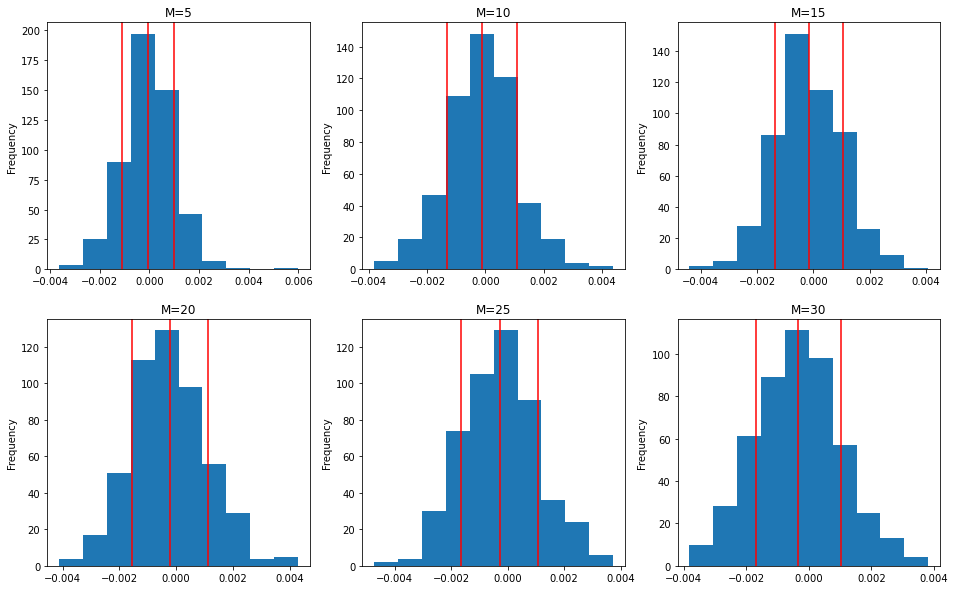

In [7]:
def construct_spread(data, assets, M):
    """Creates the spread between assets over a window.
    Arguments
    data: pd.DataFrame       containing asset and benchmark returns
    assets: list of length 2 containing the spread assets
    M: int                   accumulation window for spread"""
    strat = pd.DataFrame()
    for a, l in zip(assets, ["XR", "YR"]): strat[l] = data[("ret",a)]
    strat["tgt_size"] = data[("volm", "N_t")] / 100
    strat["signal"] = (strat["XR"].rolling(M).sum() 
                       - strat["YR"].rolling(M).sum())
    return strat
    
def vis_hist(ser, ax, stats):
    ser.plot.hist(ax=ax)
    mu = stats["mean"]; sig = stats["std"]
    ax.set_title(f"M={stats['M']}")
    ax.axvline(mu,c='r'); ax.axvline(mu+sig,c='r'); ax.axvline(mu-sig,c='r')

fig, axs = plt.subplots(2,3)
plt_counter = 0

strat_stats = []

for M in range(1,31):
    strat_ = construct_spread(etfs_facts, QUANDL_ASSETS, M)
    sig = strat_["signal"]
    
    ann = 252/M
    stats = {"M": M, "strat": strat_, "mean": sig.mean(), "std": sig.std(), 
             "amean": sig.mean()*ann, "astd": sig.std()*ann**0.5, "skew": sig.skew(),
             "kurt": sig.kurtosis()}
    strat_stats.append(stats)
    
    if not(M%5): # Plot every 5
        vis_hist(strat_["signal"], axs[plt_counter//3, plt_counter%3], stats)
        plt_counter += 1

strat_stats = pd.DataFrame(strat_stats).set_index('M')
plt.show()

## Histograms as `M` Increases

Relatively flat Mean. Decreasing annualized Standard Deviation. Skew near zero or positive. Decreasing Kurtosis (fatter tails).

Becasuse we are trading based on fixed `g` and `-g` entry parameters, we must ensure that the data does not have too significant of a mean. If mean is significant, the `g` parameter will be lopsided because one side of the entry parameter is closer to the mean and thus more likely to be triggered. Using the spread as a signal requires a non-negligible amount of volatility because we would like trades to occur when opportunities manifest. Too high standard deviation leads to excess trading (captures false signals) whereas too low standard deviation leads to insufficient trading (no money made). The data skew appears negligible, whereas the kurtosis impact the trigger of stop loss. High kurtosis indicates that the spread has more extreme values compared with normal, and this may lead the strategy to continue holding positions that have turned out of favor.

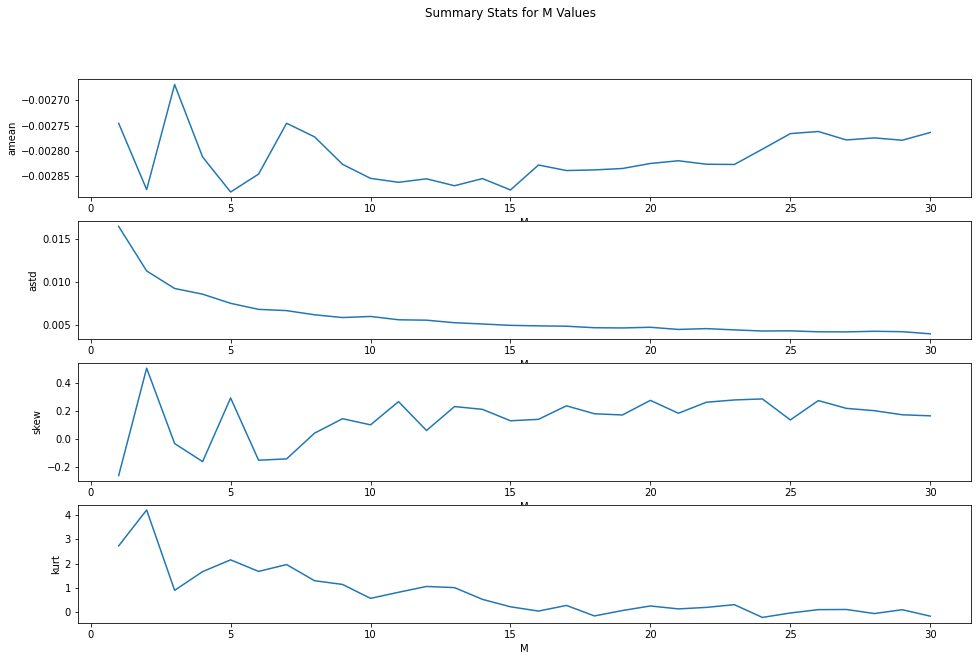

In [8]:
cols = strat_stats.columns[3:]
fig, axs = plt.subplots(len(cols))
plt.suptitle("Summary Stats for M Values")

for i, c in enumerate(cols):
    strat_stats[c].plot(ax=axs[i])
    axs[i].set_ylabel(c)
plt.show()

## Spread Summary Stats

Mean trends down, Standard Deviation trends up as $\sqrt{t}$. Skew and Kurtosis stabilize after 15.

Therefore, when tuning `g` and `j`, we should scale them according to $\sqrt{M}$. It is important to note that `g` and `j` values will obtain different results based on different `M` because the spread dynamics are different across `M`.

`M` appears to be the logical first parameter to tune, followed by `g`, `j` and `s`. 

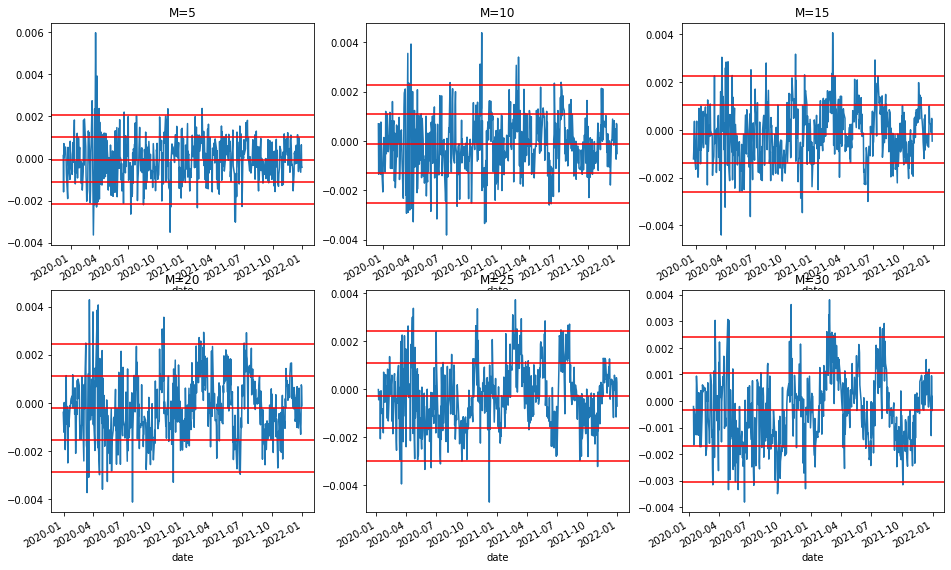

In [9]:
def ts_stats(row, ax):
    ser = row["strat"]["signal"]
    ser.plot(ax=ax)
    mu = row["mean"]; sig = row["std"]
    ax.set_title(f"M={row.name}")
    ax.axhline(mu,c='r'); ax.axhline(mu+sig,c='r'); ax.axhline(mu-sig,c='r')
    ax.axhline(mu+2*sig,c='r'); ax.axhline(mu-2*sig,c='r')

fig, axs = plt.subplots(2,3)

for i in range(6):
    ts_stats(strat_stats.loc[5*(i+1),:], axs[i//3,i%3])

plt.show()

## Spread $\mu$ and $\sigma$

Tune `g` and `j` to capture profit opportunities while not risking blowing up. `g` and `j` should be a function of $\sigma$(`M`), though we do not want to introduce lookahead bias.

`M` over 20 have spreads that cluster too significantly (reverts too slowly).

## Strategy Description

The function `construct_strategy()` groups decision making by month. Then, by using flags `>g`, `<-g`, etc., `execute_strat()` iterates through the time series and places trades accordingly. Outside of the loop, `execute_strat()` calculates profit, gross trade cost, returns, and propogates stop losses. An improvement would be to create a class for this trading strategy.

In [10]:
def construct_strategy(data, assets, g, j, s, M):
    """Creates the spread between assets over a window.
    Arguments
    data: pd.DataFrame       containing asset and benchmark returns
    assets: list of length 2 containing the spread assets
    g: float                 position entry parameter
    j: float                 position exit parameter
    s: float                 stop loss parameter
    M: int                   accumulation window for spread
    Constraint g > j > 0
    """
    # ---------------------------------------------------------------------
    def execute_strat(df, g=g, j=j, s=s, M=M):
        n = len(df)

        changes, positions = [], []
        dxs, dys, imbal = [], [], []
        x_pos, y_pos, profit = [], [], []

        # Starting day
        row = df.iloc[0]
        curr_chg = row["ltg"] - row["gtg"]
        curr_pos = curr_chg
        dx = curr_chg * row["XSz"]
        dy = -curr_chg* row["YSz"]
        imb = dx*row["XL"] + dy*row["YL"]
        x, y = 0, 0
        x += dx
        y += dy
        changes.append(curr_chg)
        positions.append(curr_pos)
        dxs.append(dx), dys.append(dy)
        imbal.append(imb)
        x_pos.append(x); y_pos.append(y)

        for i in range(1, n-1):
            row = df.iloc[i]
            if curr_pos==0: # No position
                curr_chg = row["ltg"] - row["gtg"]
                if curr_chg:
                    dx = curr_chg * row["XSz"]
                    dy = -curr_chg* row["YSz"]
                else: dx, dy = 0, 0
                
            elif curr_pos>0: # Long position
                curr_chg = -row["gtj"] - row["gtg"]
                if curr_chg==0: dx, dy = 0,0
                elif curr_chg==-1: # Crosses -j: Close
                    dx, dy = -x, -y
                elif curr_chg==-2: # Crosses -j and +g: Reverse
                    dx = -row["gtg"]* row["XSz"] - x
                    dy = row["gtg"] * row["YSz"] - y
                    
            elif curr_pos<0: # Short position
                curr_chg = row["ltj"] + row["ltg"]
                if curr_chg==0: dx, dy = 0, 0
                elif curr_chg==1: # Crosses j: Close
                    dx, dy = -x, -y
                elif curr_chg==2: # Crosses j and -g: Reverse
                    dx = row["ltg"] * row["XSz"] - x
                    dy = -row["ltg"]* row["YSz"] - y
                    
            else: # Error
                pass
            
            x += dx
            y += dy
            curr_pos += curr_chg
            imb = dx*row["XL"] + dy*row["YL"]
            changes.append(curr_chg)
            positions.append(curr_pos)
            x_pos.append(x); y_pos.append(y)
            dxs.append(dx); dys.append(dy)
            imbal.append(imb)

        # Ending day
        row = df.iloc[-1]
        curr_chg = -curr_pos
        curr_pos += curr_chg
        dx, dy = -x, -y
        imb = dx*row["XL"] + dy*row["YL"]
        x += dx
        y += dy
        changes.append(curr_chg)
        positions.append(curr_pos)
        x_pos.append(x); y_pos.append(y)
        dxs.append(dx); dys.append(dy)
        imbal.append(imb)

        trades = pd.DataFrame({"chg": changes, "pos": positions, 
                               "dX": dxs, "dY": dys,
                               "XPos": x_pos, "YPos": y_pos}, index=df.index)
        
        cols = ['chg', 'pos', 'dX', 'dY', 'XPos', 'YPos']
        trades[cols] = trades[cols].fillna(0).astype(int)
        
        trades["XVal"] = trades["XPos"].shift(1) * df["XL"].diff()
        trades["YVal"] = trades["YPos"].shift(1) * df["YL"].diff()
        trades["pl"] = trades["XVal"] + trades["YVal"]
        trades["pl"].fillna(0, inplace=True)
        
        # gtc = gross trade cost
        trades["gtc"] = np.abs(trades["XPos"]*df["XL"]-trades["YPos"]*df["YL"])
        trades["ret"] = np.log(trades["pl"] / trades["gtc"].shift(1) + 1).fillna(0)
        
        trades["comcap"] = (trades["chg"]!=0).astype(int) * trades["gtc"]
        trades["comcap"] = trades["comcap"].replace(to_replace=0, method='ffill')
        trades["stop"] = trades["comcap"] * (1-s)
        trades["stopped"] = (trades["gtc"]<trades["stop"]) & (trades["gtc"]>0.0001)
        trades["stopped"] = trades["stopped"].replace(to_replace=0, method='ffill')

        return trades
    
    # ---------------------------------------------------------------------
    
    strat = construct_spread(data, assets, M)
    signal = strat["signal"]
    
    for a, l in zip(assets, ["XL", "YL"]): strat[l] = data[("level", a)]
    strat["XSz"] = np.round(strat["tgt_size"].divide(strat["XL"],axis=0))
    strat["YSz"] = np.round(strat["tgt_size"].divide(strat["YL"],axis=0))
    
    strat["gtg"] = signal > g
    strat["ltg"] = signal < -g
    strat["gtj"] = signal > -j
    strat["ltj"] = signal < j
    
    if True: # Debug
        to_ints = ["gtg", "ltg", "gtj", "ltj"]
        strat[to_ints] = strat[to_ints].astype(int)
    
    strat["year"] = strat.index.year
    strat["month"] = strat.index.month
    
    trades = strat.groupby(["year", "month"]).apply(execute_strat)
    
    strat = pd.concat([trades, strat], axis=1)
    
    K = 2 * strat["tgt_size"].max()
    # Return on capital
    strat["roc"] = np.log((strat["pl"]+K) / K)
    
    cols = ['chg', 'pos', 'dX', 'dY', 'XPos', 'YPos', 
            'pl', 'ret', 'roc']
    strat.loc[strat["stopped"], cols] = 0
    return strat

## First Test of Strategy

Using arbitrary parameters from a visual insepction of the spread plot (lookahead bias introduced here).

In [11]:
g = 0.001   # Entry parameter
j = 0.00015 # Exit parameter
s = 0.01    # Stop Loss parameter
M = 10      # Accumulation window to determine spread divergence

strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
mask = (strat["year"]==2020) & (strat["month"]==1)

cols = ['chg', 'pos', 'dX', 'dY', 'XPos', 'YPos', 
        'signal', 'XL', 'YL', 'pl', 'gtc', 'stop', 'ret']
strat[mask][cols].head()

,chg,pos,dX,dY,XPos,YPos,signal,XL,YL,pl,gtc,stop,ret
date,,,,,,,,,,,,,
2020-01-02,0,0,0,0,0,0,0.0001,35.5481,93.3144,0.0000,0.0000,0.0000,0.0000
2020-01-03,0,0,0,0,0,0,-0.0007,35.4008,92.9412,-0.0000,0.0000,0.0000,0.0000
2020-01-06,1,1,489,-186,489,-186,-0.0013,35.7838,94.0411,0.0000,34989.9404,34640.0410,0.0000
2020-01-07,0,1,0,0,489,-186,-0.0008,35.8231,94.1000,8.2534,35020.1131,34640.0410,0.0002
2020-01-08,-2,-1,-994,378,-505,192,0.0012,36.0392,94.5812,16.1678,36359.4040,35995.8099,0.0005


In [12]:
stop_mask = (strat["stopped"]&(~strat["stopped"].shift(1, fill_value=False)))
strat[stop_mask][cols].head()

,chg,pos,dX,dY,XPos,YPos,signal,XL,YL,pl,gtc,stop,ret
date,,,,,,,,,,,,,
2020-01-24,0,0,0,0,0,0,-0.0002,36.5304,95.8383,0.0000,75158.3306,75221.4608,0.0000
2020-02-21,0,0,0,0,0,0,-0.0012,36.8840,96.9971,0.0000,69981.9463,70271.3032,0.0000
2020-03-03,0,0,0,0,0,0,-0.0023,33.2496,87.4614,0.0000,71889.4365,73465.6917,0.0000
2020-06-24,0,0,0,0,0,0,-0.0003,35.1060,92.3690,0.0000,73193.6847,73590.5076,0.0000
2020-07-13,0,0,0,0,0,0,-0.0024,36.2815,95.7039,0.0000,54450.4146,55042.0396,0.0000


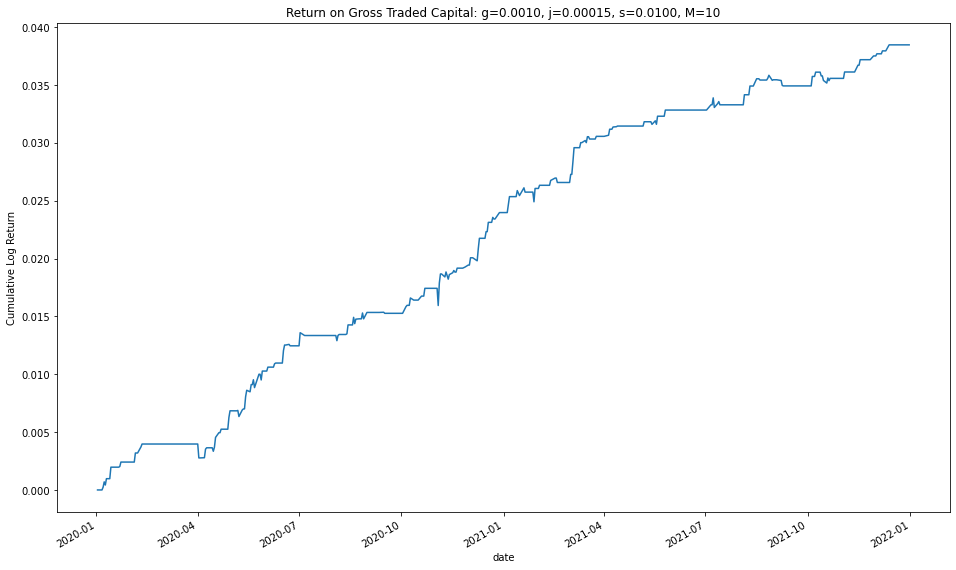

In [13]:
strat["2020":]["ret"].cumsum().plot()
plt.title(f"Return on Gross Traded Capital: g={g:.4f}, j={j:.5f}, s={s:.4f}, M={M}")
plt.ylabel("Cumulative Log Return")
plt.show()

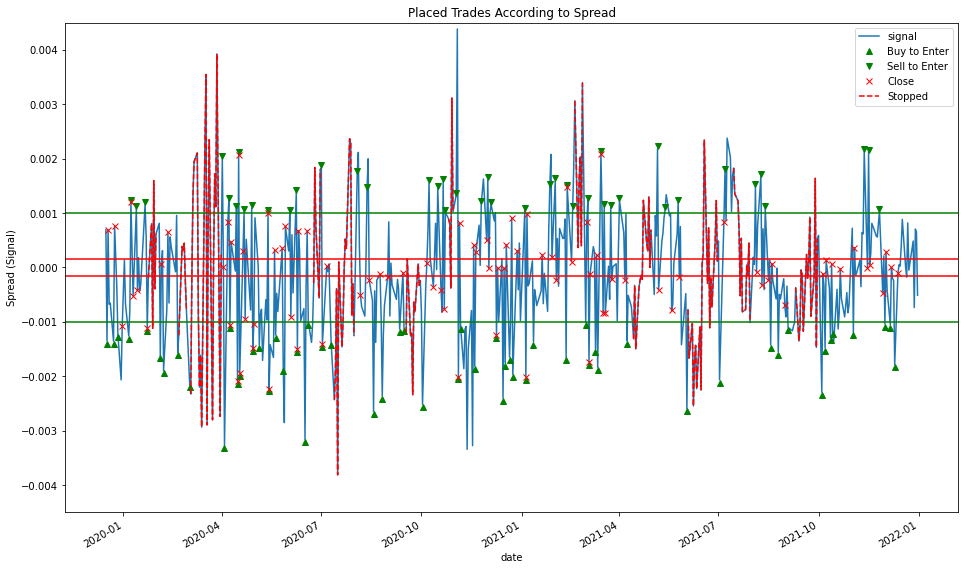

In [14]:
def visualize_strat(strat, g, j, ep=0.00005, yl=0.0045):
    fig, ax = plt.subplots()
    ax.set_ylim([-yl,yl])
    
    strat["signal"].plot(ax=ax)
    ax.axhline(g, c="g"); ax.axhline(-g, c="g")
    ax.axhline(j, c="r"); ax.axhline(-j, c="r")
    
    buy_to_enter = (strat["chg"]==1) & (strat["pos"].shift(1)==0)
    sell_to_enter = (strat["chg"]==-1) & (strat["pos"].shift(1)==0)
    buy_to_close = (strat["chg"]==1) & (strat["pos"].shift(1)!=0)
    sell_to_close = (strat["chg"]==-1) & (strat["pos"].shift(1)!=0)
    reverse_up = strat["chg"]==2
    reverse_down = strat["chg"]==-2
    
    ax.plot(strat.loc[buy_to_enter,"signal"]-ep, marker='^', ls='', color='g', label="Buy to Enter")
    ax.plot(strat.loc[buy_to_close,"signal"], marker='x', ls='', color='r')
    ax.plot(strat.loc[sell_to_enter,"signal"]+ep, marker='v', ls='', color='g', label="Sell to Enter")
    ax.plot(strat.loc[sell_to_close,"signal"], marker='x', ls='', color='r', label="Close")
    ax.plot(strat.loc[reverse_up,"signal"]-ep, marker='^', ls='', color='g')
    ax.plot(strat.loc[reverse_down,"signal"]+ep, marker='v', ls='', color='g')
    ax.plot(strat.loc[reverse_up,"signal"], marker='x', ls='', color='r')
    ax.plot(strat.loc[reverse_down,"signal"], marker='x', ls='', color='r')
    stopped = strat[["stopped", "signal"]].copy(deep=True)
    stopped[~stopped["stopped"]] = np.nan
    ax.plot(stopped["signal"], ls='--', color='r', label="Stopped")
    plt.title("Placed Trades According to Spread")
    plt.ylabel("Spread (Signal)")
    plt.legend()
    plt.show()
    
visualize_strat(strat, g, j)

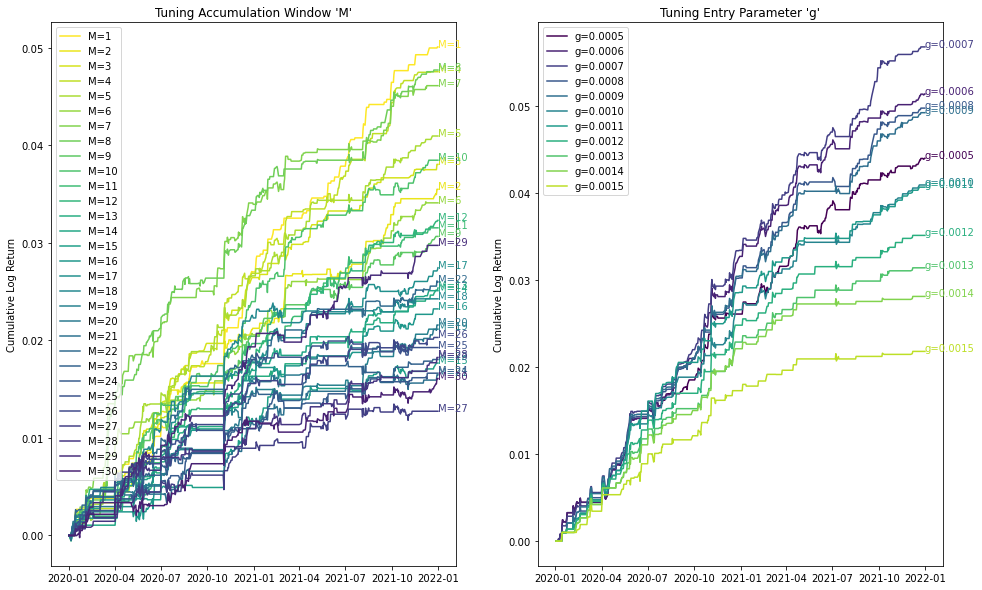

In [15]:
g = 0.001   # Entry parameter
j = 0.00015 # Exit parameter
s = 0.01    # Stop Loss parameter
# M = 10      # Accumulation window to determine spread divergence

fig, axs = plt.subplots(1,2)

minim = 1
maxim = 31
Ms = range(minim,maxim)

for i, M in enumerate(Ms):
    strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
    plot_ser = strat["2020":]["ret"].cumsum()
    colo = cm.viridis(255-i*8)
    axs[0].plot(plot_ser, c=colo, label=f"M={M}")
    axs[0].annotate(f"M={M}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    axs[0].set_ylabel("Cumulative Log Return")

axs[0].set_title("Tuning Accumulation Window 'M'")
axs[0].legend()

# g = 0.001   # Entry parameter
j = 0.00015 # Exit parameter
s = 0.01    # Stop Loss parameter
M = 5       # Accumulation window to determine spread divergence

minim = 0.0005
maxim = 0.0015
gs = np.linspace(minim, maxim, 11)

for i, g in enumerate(gs):
    strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
    plot_ser = strat["2020":]["ret"].cumsum()
    colo = cm.viridis(i*23)
    axs[1].plot(plot_ser, c=colo, label=f"g={g:.4f}")
    axs[1].annotate(f"g={g:.4f}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    axs[1].set_ylabel("Cumulative Log Return")

axs[1].set_title("Tuning Entry Parameter 'g'")
axs[1].legend()

plt.show()

## Tune Accumulation Window `M`

`M` impacts signal strength and balances information against overtrading. Higher `M` leads to the failure to respond accurately to signals due to the high amount of spread data accumulation.

## Tune Entry Parameter `g`

`g` $\in [0.0006, 0.0007, 0.0008, 0.0009]$ yields the highest return. We observe that a strategy with `g` too high or too low will have depressed returns because it trades too infrequently or too foolishly, respectively.

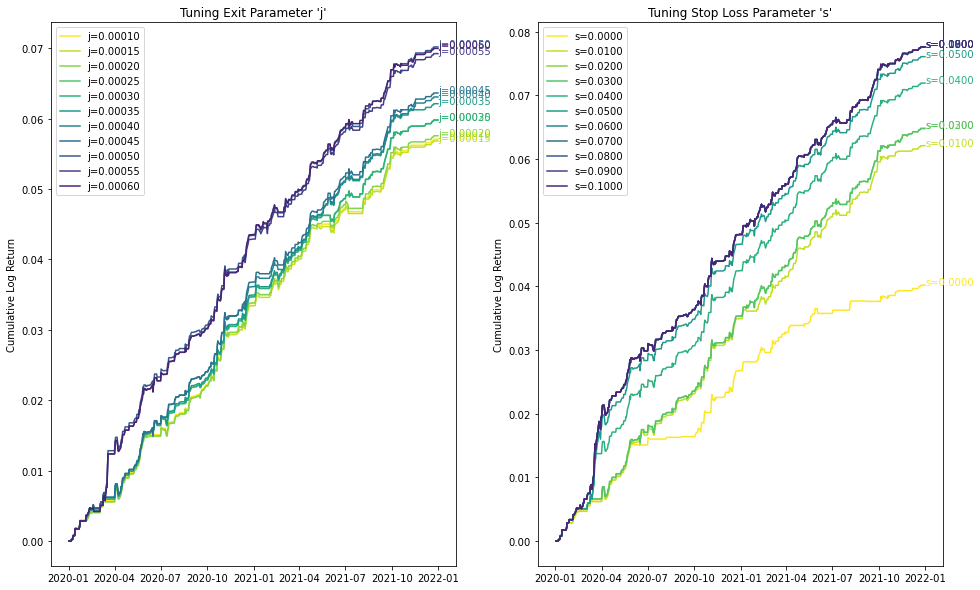

In [16]:
g = 0.0007  # Entry parameter
# j = 0.00015 # Exit parameter
s = 0.01    # Stop Loss parameter
M = 5       # Accumulation window to determine spread divergence

fig, axs = plt.subplots(1,2)

minim = 0.0001
maxim = 0.0006
js = np.linspace(minim, maxim, 11)

for i, j in enumerate(js):
    strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
    plot_ser = strat["2020":]["ret"].cumsum()
    colo = cm.viridis(255-i*23)
    axs[0].plot(plot_ser, c=colo, label=f"j={j:.5f}")
    axs[0].annotate(f"j={j:.5f}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    axs[0].set_ylabel("Cumulative Log Return")

axs[0].set_title("Tuning Exit Parameter 'j'")
axs[0].legend()

g = 0.0007  # Entry parameter
j = 0.00035 # Exit parameter
# s = 0.01    # Stop Loss parameter
M = 5       # Accumulation window to determine spread divergence

minim = 0.0
maxim = 0.1
ss = np.linspace(minim, maxim, 11)

for i, s in enumerate(ss):
    strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
    plot_ser = strat["2020":]["ret"].cumsum()
    colo = cm.viridis(255-i*23)
    axs[1].plot(plot_ser, c=colo, label=f"s={s:.4f}")
    axs[1].annotate(f"s={s:.4f}", xy=(plot_ser.index[-1], plot_ser.iloc[-1]), c=colo)
    axs[1].set_ylabel("Cumulative Log Return")

axs[1].set_title("Tuning Stop Loss Parameter 's'")
axs[1].legend()

plt.show()

## Tune Exit Parameter `j`

`j` tuning tends to be consistent, as long as its value is not set too small (i.e `j` < 0.00020). `j` > 0.00050 indeed returns higher than the lower values, but this is solely attributed to a few trades in March 2020. Its out of sample performance may not be robust in this case. Therefore we choose a parameter near the middle of the distribution.

## Tune Stop Loss Parameter `s`

`s` measures the strategy's volatility averseness. However, taking no risk leads to no reward, as we see in `s`=0.0000 (closes the position if next day moves against the strategy). Therefore, it is important to balance the `s` thresshold to disallow catastrophic drawdowns. We observe a diminishing return with `s` > 0.0500.

## Tuned Strategy

The following parameters were chosen to maximize profit while remaining robust. This is a good place to start a grid search.

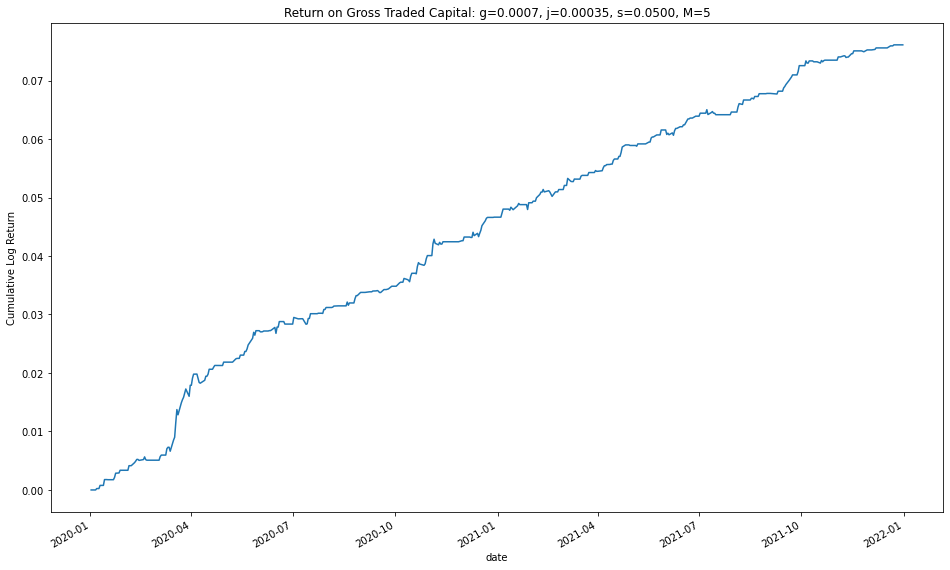

In [17]:
g = 0.0007  # Entry parameter
j = 0.00035 # Exit parameter
s = 0.05    # Stop Loss parameter
M = 5       # Accumulation window to determine spread divergence

strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
strat["2020":]["ret"].cumsum().plot()
plt.title(f"Return on Gross Traded Capital: g={g:.4f}, j={j:.5f}, s={s:.4f}, M={M}")
plt.ylabel("Cumulative Log Return")
plt.show()

## Grid Search Optimization

Now that we have a starting point, we can start a grid search to find the optimal parameters. The above strategy is likely the result of a local maximum; hihgly unlikely to be the global maximum. Therefore, we shall continue our search! Note: some parameters such as `M` and `g` have a higher impact on returns compared with less important ones such as `g`. Therefore, the grid search will use more iterations on the more important parameters.

In [18]:
g = 0.0007  # Entry parameter
j = 0.00035 # Exit parameter
s = 0.05    # Stop Loss parameter
M = 5       # Accumulation window to determine spread divergence

Ms = range(1,11)
gs = np.linspace(0.0005, 0.0010, 6)
js = np.linspace(0.00015, 0.00055, 3)
ss = np.linspace(0.03, 0.07, 5)

nsim = np.prod([len(l) for l in [Ms, gs, js, ss]])

strat_dict = {}
print(f"Running {nsim} simulations...")
for i, M in enumerate(Ms):
    print(f"Status: {i/len(Ms)*100:.0f}%")
    for g in gs:
        for j in js:
            for s in ss:
                strat_dict[(M, g, j, s)] = construct_strategy(
                    etfs_facts, QUANDL_ASSETS, g, j, s, M)

print("Done!")

Running 900 simulations...
Status: 0%
Status: 10%
Status: 20%
Status: 30%
Status: 40%
Status: 50%
Status: 60%
Status: 70%
Status: 80%
Status: 90%
Done!


In [19]:
sum_cols = pd.MultiIndex.from_tuples([(M, g, j, s) for M in Ms
                                      for g in gs for j in js
                                      for s in ss], names=
                                     ["M", "g", "j", "s"])

strat_grid = pd.DataFrame()
for c in sum_cols:
    strat_grid[c] = strat_dict[c]["ret"]
    
strat_grid.columns = sum_cols
strat_defrag = strat_grid.copy()

<ipython-input-19-bb4a9dc691dc>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  strat_grid[c] = strat_dict[c]["ret"]


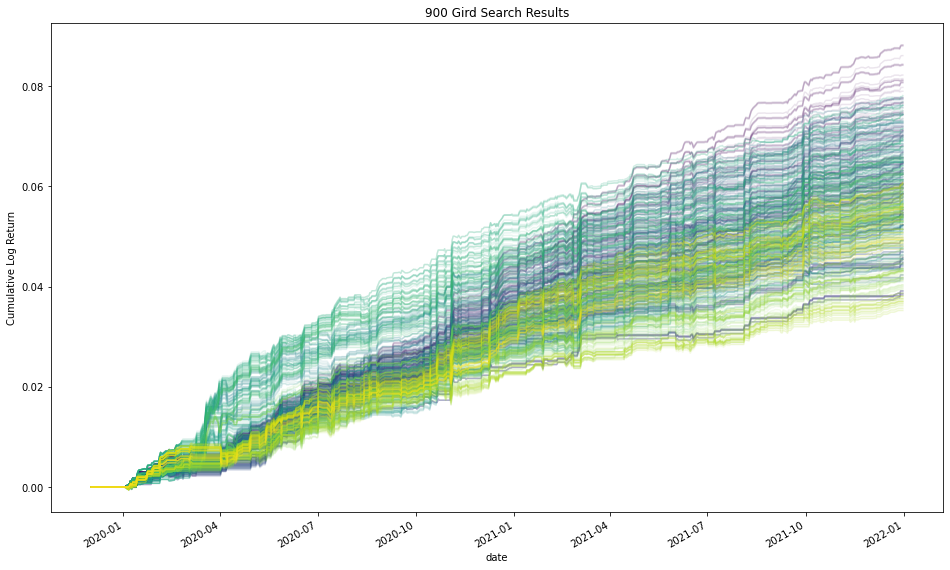

In [20]:
cstep = 255/len(strat_defrag.columns)

for i, c in enumerate(strat_defrag.columns):
    to_plot = strat_defrag[c].cumsum()
    colo = cm.viridis(round(i*cstep))
    to_plot.plot(label=None, c=colo, alpha=0.1)

plt.title(f"{nsim} Gird Search Results")
plt.ylabel("Cumulative Log Return")
plt.show()

## Why do High Performers Succeed?

Establish a `thresh`, look at the parameters shared by high performers!

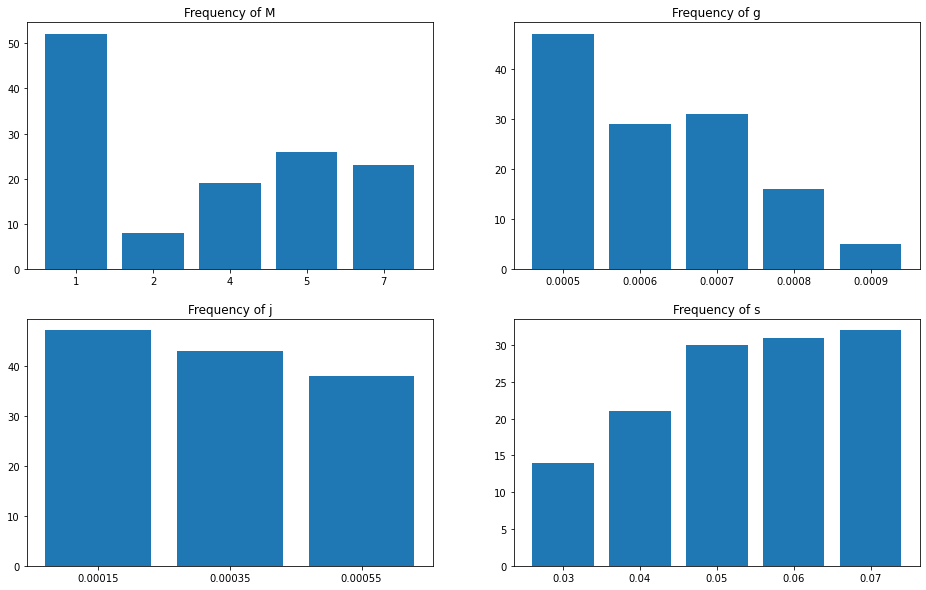

In [21]:
thresh = 0.07

high_perf = strat_defrag.loc[:,strat_defrag.cumsum().iloc[-1] > thresh]

fig, axs = plt.subplots(2,2)

for i, c in enumerate(high_perf.columns.names):
    x, y = zip(*Counter(high_perf.columns.get_level_values(i)).items())
    x = [str(round(i,5)) for i in x]
    axs[i//2,i%2].bar(x,y)
    axs[i//2,i%2].set_title(f"Frequency of {c}")

plt.show()

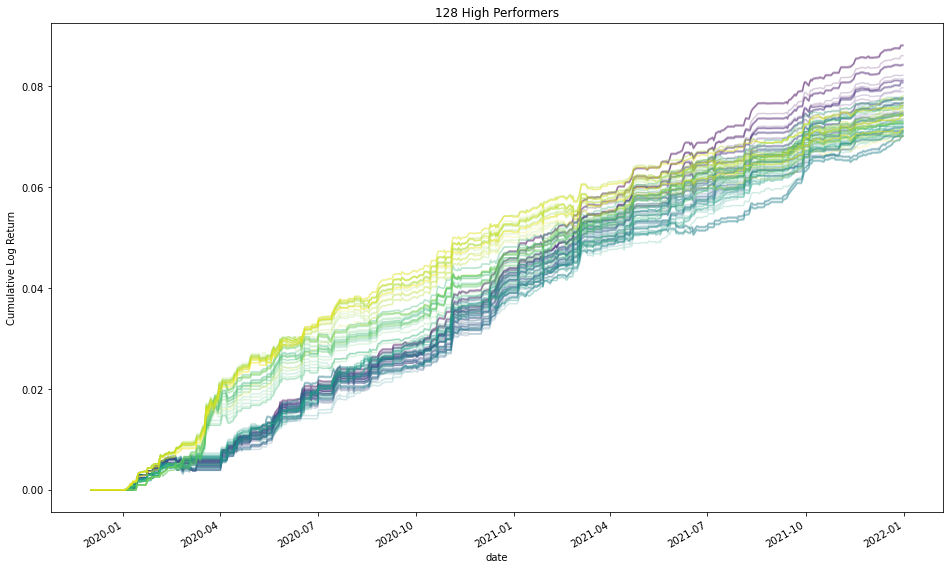

In [22]:
cstep = 255/len(high_perf.columns)

for i, c in enumerate(high_perf.columns):
    to_plot = high_perf[c].cumsum()
    colo = cm.viridis(round(i*cstep))
    to_plot.plot(label=None, c=colo, alpha=0.2)

plt.title(f"{len(high_perf.columns)} High Performers")
plt.ylabel("Cumulative Log Return")
plt.show()

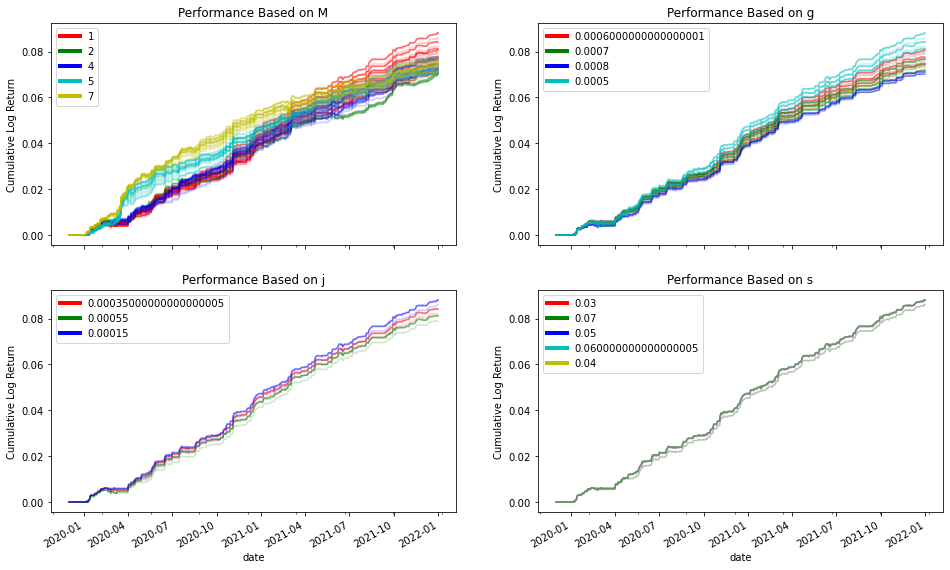

In [23]:
fig, axs = plt.subplots(2,2)

axs[0,0].sharex(axs[1,0])
axs[0,1].sharex(axs[1,1])

Mslice = high_perf.columns.get_level_values(0)
colo = ['r','g','b','c','y','m']

lin = []
lab = []
for i, M in enumerate(set(Mslice)):
    lin.append(Line2D([0], [0], color=colo[i], lw=4))
    lab.append(M)
    high_perf.loc[:,Mslice==M].cumsum().plot(ax=axs[0,0], c=colo[i], alpha=0.2)

axs[0,0].legend(lin, lab)
axs[0,0].set_title(f"Performance Based on M")
axs[0,0].set_ylabel("Cumulative Log Return")

bestM = high_perf.loc[:,Mslice==1]

gslice = bestM.columns.get_level_values(1)

lin = []
lab = []
for i, g in enumerate(set(gslice)):
    lin.append(Line2D([0], [0], color=colo[i], lw=4))
    lab.append(g)
    bestM.loc[:,gslice==g].cumsum().plot(ax=axs[0,1], c=colo[i], alpha=0.2)

axs[0,1].legend(lin, lab)
axs[0,1].set_title(f"Performance Based on g")
axs[0,1].set_ylabel("Cumulative Log Return")

bestg = bestM.loc[:,gslice==0.0005]

jslice = bestg.columns.get_level_values(2)

lin = []
lab = []
for i, j in enumerate(set(jslice)):
    lin.append(Line2D([0], [0], color=colo[i], lw=4))
    lab.append(j)
    bestg.loc[:,jslice==j].cumsum().plot(ax=axs[1,0], c=colo[i], alpha=0.2)

axs[1,0].legend(lin, lab)
axs[1,0].set_title(f"Performance Based on j")
axs[1,0].set_ylabel("Cumulative Log Return")

bestj = bestg.loc[:,jslice==0.00015]

sslice = bestj.columns.get_level_values(3)

lin = []
lab = []
for i, s in enumerate(set(sslice)):
    lin.append(Line2D([0], [0], color=colo[i], lw=4))
    lab.append(s)
    bestg.loc[:,jslice==j].cumsum().plot(ax=axs[1,1], c=colo[i], alpha=0.1)

axs[1,1].legend(lin, lab)
axs[1,1].set_title(f"Performance Based on s")
axs[1,1].set_ylabel("Cumulative Log Return")
plt.show()

plt.show()

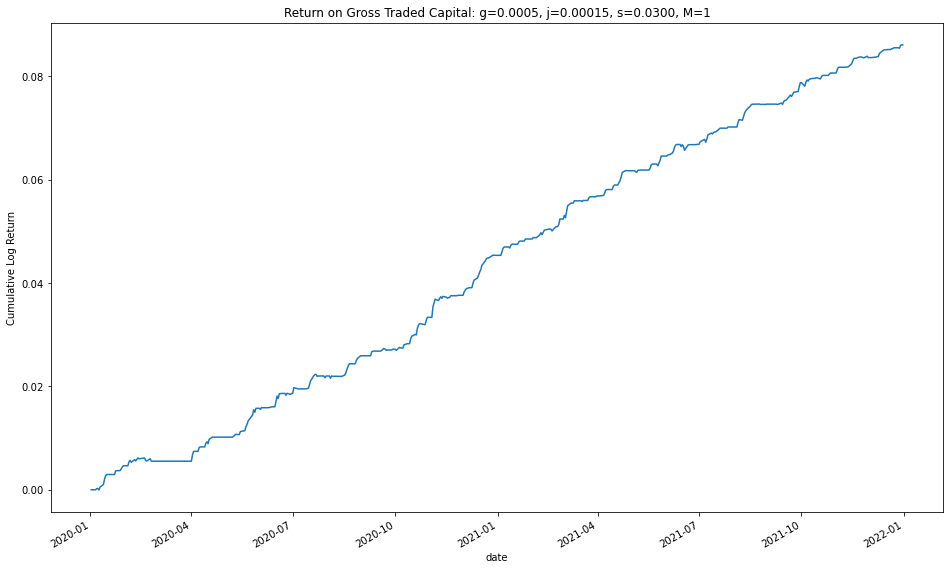

In [24]:
M = 1
g = 0.0005
j = 0.00015
s = 0.03

strat = construct_strategy(etfs_facts, QUANDL_ASSETS, g, j, s, M)
strat["2020":]["ret"].cumsum().plot()
plt.title(f"Return on Gross Traded Capital: g={g:.4f}, j={j:.5f}, s={s:.4f}, M={M}")
plt.ylabel("Cumulative Log Return")
plt.show()

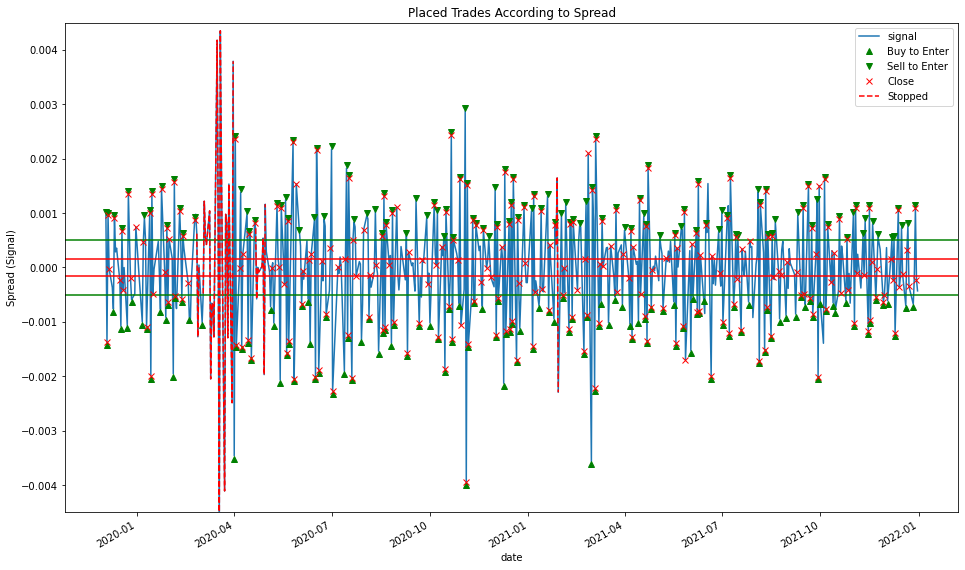

In [25]:
visualize_strat(strat, g, j)

# 4 Analysis

Study the performance of your strategy as you vary j, g, s, and M. Include plots. You need not run a fancy nonlinear optimizer, but try to find which parameters work well, and explain how you did it. For one or more of the better settings you find, look into correlations to Fama French factor returns.
Be sure to highlight which ETF pair you are analyzing.

## Trade Analysis

The above trade plot details the entry, exists, reversals, and stops of the strategy. Notably, the strategy hit stop loss at March 2020. Furthermore, it is important to see that `g` and `j` parameters are set relatively close together. This setting is in response to the spread's tendency to "bounce" (negative autoregression, strong mean reversion).

Note: "roc" is return on capital ($\frac{\text{price diff}}{K}$) whereas "ret" is return on invested capital ($\frac{\text{price diff}}{\text{position size}}$). Tuning the strategy used "ret" whereas performance analysis uses "roc". There is only a linear difference that "ret" ~ 2 * "roc".

In [26]:
factors = etfs_facts["ret"].columns[2:-1]

decomp = strat["2020":][["ret", "roc"]].merge(etfs_facts["ret"][factors], on="date").dropna()
decomp.head(3)

,ret,roc,Mkt-RF,SMB,HML
date,,,,,
2020-01-02,0.0000,0.0000,0.0086,-0.0089,-0.0032
2020-01-03,0.0000,0.0000,-0.0067,0.0039,0.0000
2020-01-06,0.0000,0.0000,0.0036,-0.0007,-0.0054


In [27]:
endo = decomp[["roc"]]
exog = sm.add_constant(decomp[factors])

res = sm.OLS(endo, exog).fit()
res.summary()

/Users/plee/miniconda3/envs/finmath/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roc   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.709
Date:                Thu, 27 Jan 2022   Prob (F-statistic):              0.164
Time:                        23:10:03   Log-Likelihood:                 3674.2
No. Observations:                 505   AIC:                            -7340.
Df Residuals:                     501   BIC:                            -7324.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.236e-05    7.5e-06     10.985      0.000    6.76e-05    9.71e-05
Mkt-RF         0.0010      0.000      2.228      0.026       0.000       0.002
SMB         4.924e-05      0.001      0.056      0.956      -0.002       0.002
HML           -0.0003      0.001     -0.628      0.530      -0.001       0.001
==============================================================================
Omnibus:                      128.991   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.746
Skew:                           1.279   Prob(JB):                     8.25e-71
Kurtosis:                       5.966   Cond. No.                         120.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression Analysis

The Linear Factor Decomposition using the Fama-French 3-Factor model yields a hedging $R^2$ of 0.01. The strategy is significantly explained by Market, SMB and HML factors. It is worthy to note that the coefficients are extremely small because the spread stragegy has low returns comapred with the factors.

In [28]:
ret, reg = portstats_bm(decomp[["roc"]], decomp[factors], nper=252, logret=False)
ret

,mean,std,sharpe,alpha,beta_Mkt-RF,beta_SMB,beta_HML,r2,mae,treynor,info ratio,drawdown,peak,trough,recovery
roc,0.0210,0.0027,7.8511,0.0208,0.0010,0.0000,-0.0003,0.0101,0.0208,20.5187,7.7984,-0.0004,2021-06-14,2021-06-18,2021-06-29


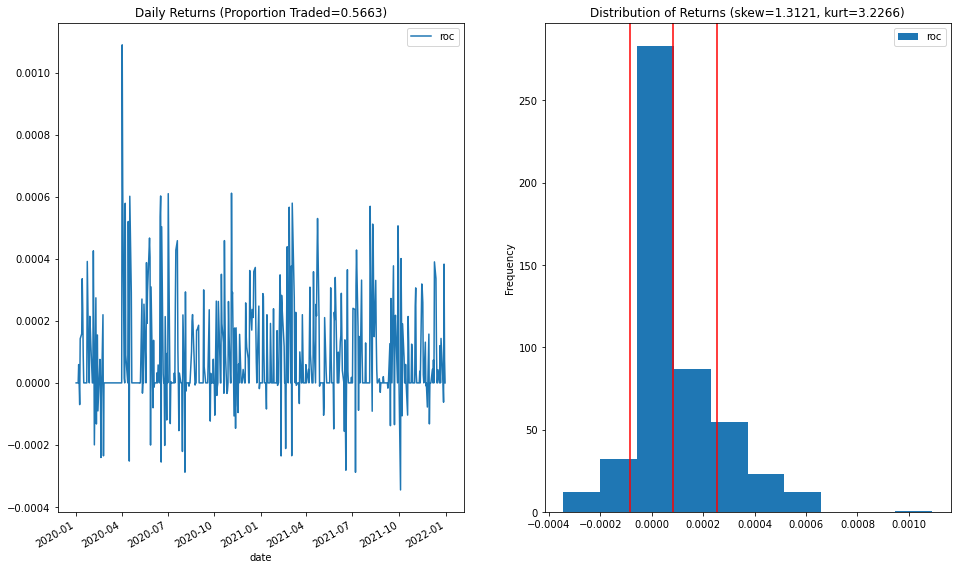

In [29]:
fig, axs = plt.subplots(1,2)

roc = decomp[["roc"]]
pro_traded = (roc!=0).sum()[0]/len(roc)

roc.plot(ax=axs[0])
axs[0].set_title(f"Daily Returns (Proportion Traded={pro_traded:.4f})")

mu = roc.mean()[0]
sig = roc.std()[0]
s = roc.skew()[0]
k = roc.kurtosis()[0]
roc.plot.hist(ax=axs[1])
axs[1].set_title(f"Distribution of Returns (skew={s:.4f}, kurt={k:.4f})")
axs[1].axvline(mu, c='r')
axs[1].axvline(mu+sig, c='r')
axs[1].axvline(mu-sig, c='r')

plt.show()

## Summary

Using `M`=1 unlocked a significant amount of the strategy's potential. Compared with `M`=5, the strategy performed significanly more consistently. It triggered stop loss in March 2020, avoiding drawdown but also missing significant oppotuntiy captured by `M`=5. However, this stop loss is actually beneficial to the strategy's robustness.

Ultimately, this strategy performs consistently with minimal volatility, an accompanying low return, but also stellar measures including a Sharpe Ratio of 7.9, an Information Ratio of 7.8, and a Treynor Measure of 20.5 while only holding positions for 57% of the time. Overall, this strategy will likely prove successful if implemented in conjunction with other spread trading strategies.